# Consumption and growth rates
The goal of this notebook is to calculate consumption and growth rate from time course data.


<br>
Input: time vs. substrate data and time vs. biomass data
<br>
Output: consumption rate with unit $\frac{mmol substrate consumed}{g biomass*hr}$  and the growth rate with unit hr$^-$$^1$.

### Setup

In [248]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import math
from scipy.stats import linregress
from scipy import mean


GRAMS_BIOMASS_PER_LITER_PER_OD = 0.35 # 1 OD = 0.35 g/L of biomass

### Yoneda et al. growth curves
Load OD and substrate concentration curves

In [249]:
od_filename = '../../EDD_Yoneda_data/Yoneda_set2_ODD_data.csv'
substrate_filename = '../../EDD_Yoneda_data/Yoneda_set2_Metabolomics_data.csv'

od_df = pd.read_csv(od_filename)
sub_df = pd.read_csv(substrate_filename)

od_df['Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*od_df['Value']

print(f'substrate data has {len(sub_df)} lines')
print(f'OD data has {len(od_df)} lines')

substrate data has 84 lines
OD data has 63 lines


### Define function that takes in a single trial and returns growth rate and substrate yield

In [250]:
def stats_for_trial(growth_data, substrate_data, molar_mass, display=False):
    
    biomass_values = growth_data['Biomass Conc']
    biomass_times = growth_data['Time']
    biomass_init = list(biomass_values)[0]

    substrate_values = substrate_data['Value']*1000/molar_mass
    substrate_times = substrate_data['Time']
    substrate_init = list(substrate_values)[0]
    
    # growth is the slope of log(biomass) vs. time
    growth_rate, _, _, _, _ = linregress(biomass_times, [math.log(val) for val in biomass_values])
    
    # biomass X = X0*e^(μ*t)
    biomass_sim = [biomass_init*math.exp(growth_rate*time) for time in biomass_times]
    
    # actual consumption = S0 - S
    sub_consumed = [substrate_init - sub_value for sub_value in substrate_values]
    
    # new biomass X = X0 - X
    biomass_sim_growth = [sim_value - biomass_init for sim_value in biomass_sim ]
    
    # yield is the amount of biomass that can be made from a mmol of substrate
    yield_coeff, _, _, _, _ = linregress(sub_consumed, biomass_sim_growth)

    # S = S0 - (1/yield)*X
    substrate_sim = [substrate_init - 1/yield_coeff*val for val in biomass_sim_growth]
    
    # units work out to mmol substrate consumed / (g biomass * hr)
    substrate_consumption_rate = (1/yield_coeff) * growth_rate

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
    axes[0].plot(biomass_times, biomass_values, 'o', color='black')
    axes[0].plot(biomass_times, biomass_sim, '-', color='black')
    axes[1].plot(substrate_times, substrate_values, 'o', color='blue')
    axes[1].plot(substrate_times, substrate_sim, '-', color='blue')
    axes[0].set_title('Biomass growth')
    axes[1].set_title('Phenol consumption')
    axes[0].set_xlabel('Time (hr)')
    axes[1].set_xlabel('Time (hr)')
    axes[0].set_ylabel('Biomass (g/L)')
    axes[1].set_ylabel('Phenol (mmol/L)')
    fig.tight_layout()
    
    if display:
        print(f'growth_rate = {growth_rate:.3f} hr-1')
        print(f'yield coefficient = {yield_coeff:.3f} g biomass / mmol substrate')
        print(f'substrate consumption rate = {substrate_consumption_rate:.3f} mmol substrate/gram biomass * hr')
    else:
        return growth_rate, yield_coeff, substrate_consumption_rate

### Define function to calculate growth_rate, yield coefficient, and substrate consumption for a given condition
take in 3 trial names and molar mass, and output growth rate, yield coefficients, and substrate consumption rate

In [251]:
def stats_for_condtion(od_df, sub_df, trial_1, trial_2, trial_3, molar_mass, max_time=0):
    
    if max_time != 0:
        od_df = od_df[od_df['Time'] < max_time]
        sub_df = sub_df[sub_df['Time'] < max_time]
        
    od_1 = od_df[od_df['Line Name'] == trial_1]
    sub_1 = sub_df[sub_df['Line Name'] == trial_1]

    od_2 = od_df[od_df['Line Name'] == trial_2]
    sub_2 = sub_df[sub_df['Line Name'] == trial_2]

    od_3 = od_df[od_df['Line Name'] == trial_3]
    sub_3 = sub_df[sub_df['Line Name'] == trial_3]

    gr_1, yc_1, scr_1 = stats_for_trial(od_1, sub_1, molar_mass)
    gr_2, yc_2, scr_2 = stats_for_trial(od_2, sub_2, molar_mass)
    gr_3, yc_3, scr_3 = stats_for_trial(od_3, sub_3, molar_mass)

    print(f'growth_rate = {np.average([gr_1, gr_2, gr_3]):.3f} ± {np.std([gr_1, gr_2, gr_3]):.3f} hr-1')
    print(f'yield coefficient = {np.average([yc_1, yc_2, yc_3]):.3f} ± {np.std([yc_1, yc_2, yc_3]):.3f} g biomass / mmol substrate')
    print(f'substrate consumption rate = {np.average([scr_1, scr_2, scr_3]):.3f} ± {np.std([scr_1, scr_2, scr_3]):.3f} mmol substrate/gram biomass * hr')

### Stats for WT phenol condition

growth_rate = 0.019 ± 0.001 hr-1
yield coefficient = 0.027 ± 0.003 g biomass / mmol substrate
substrate consumption rate = 0.703 ± 0.033 mmol substrate/gram biomass * hr


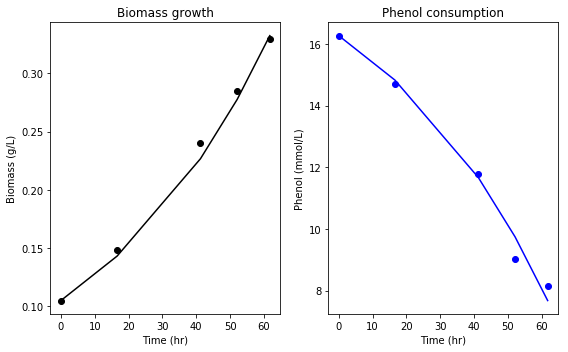

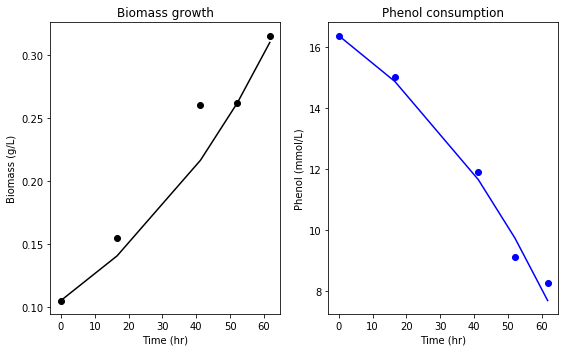

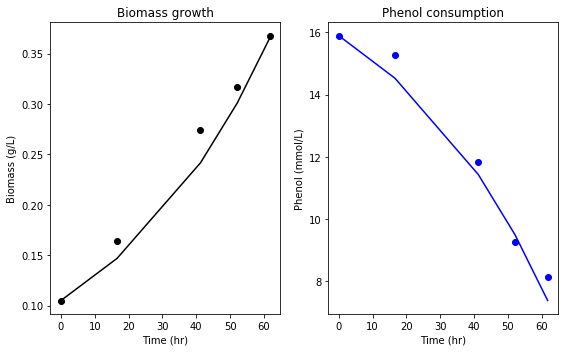

In [252]:
stats_for_condtion(od_df, sub_df, 'WT-R1', 'WT-R2', 'WT-R3', 94.11)

### Stats for Evol33 phenol condition

growth_rate = 0.034 ± 0.002 hr-1
yield coefficient = 0.033 ± 0.002 g biomass / mmol substrate
substrate consumption rate = 1.014 ± 0.021 mmol substrate/gram biomass * hr


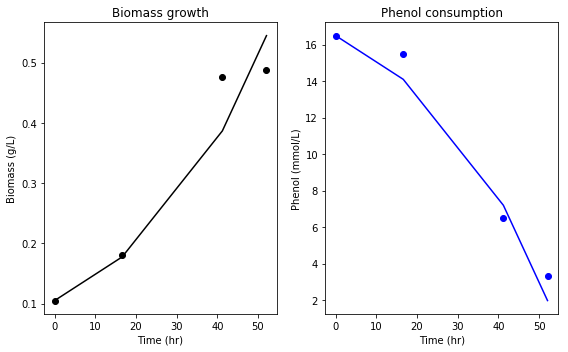

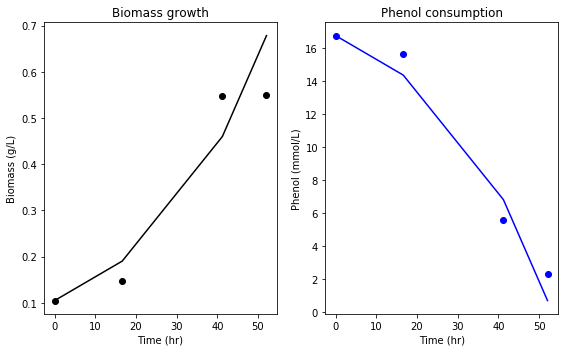

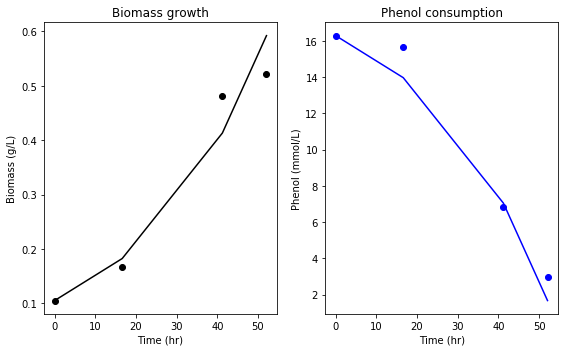

In [255]:
stats_for_condtion(od_df, sub_df, 'EVOL33-R1', 'EVOL33-R2', 'EVOL33-R3', 94.11, max_time=60)

### Stats for Evol40 phenol condition

growth_rate = 0.034 ± 0.001 hr-1
yield coefficient = 0.036 ± 0.002 g biomass / mmol substrate
substrate consumption rate = 0.943 ± 0.030 mmol substrate/gram biomass * hr


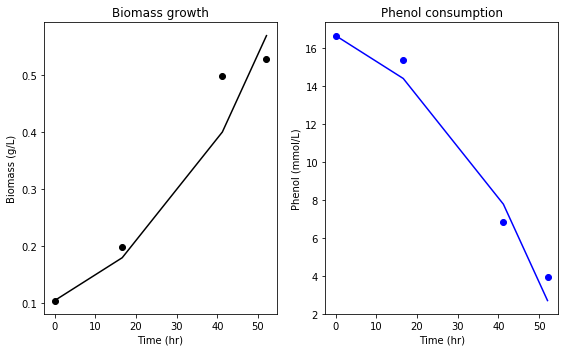

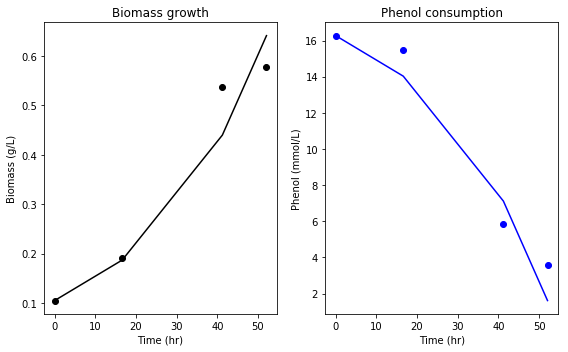

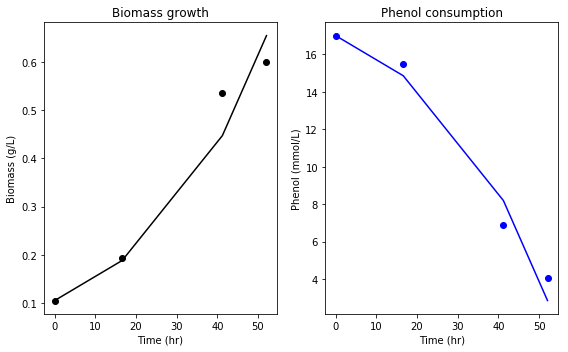

In [257]:
stats_for_condtion(od_df, sub_df, 'EVOL40-R1', 'EVOL40-R2', 'EVOL40-R3', 94.11,  max_time=60)

### Glucose data looks wrong. 
Why is starting concentration ~0.05 g/L? This is much too low to be reasonable

### Stats for WT glucose condition

growth_rate = 0.032 hr-1
yield coefficient = 1.150 g biomass / mmol substrate
substrate consumption rate = 0.027 mmol substrate/gram biomass * hr


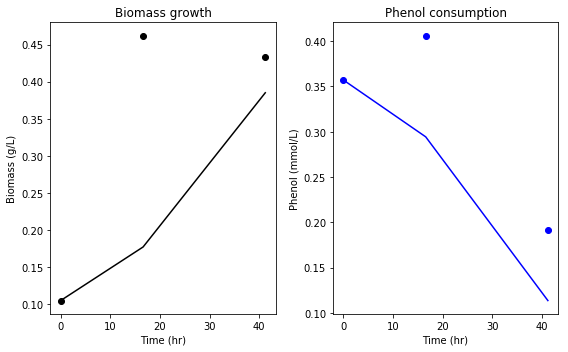

In [237]:
od_1 = od_df[od_df['Line Name'] == 'WT-G']
sub_1 = sub_df[sub_df['Line Name'] == 'WT-G']

stats_for_trial(od_1, sub_1, 180.16, display=True)

### Stats for Evol33 glucose condition

growth_rate = 0.031 hr-1
yield coefficient = 0.726 g biomass / mmol substrate
substrate consumption rate = 0.043 mmol substrate/gram biomass * hr


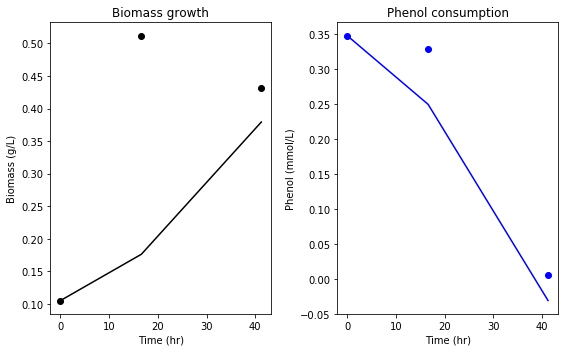

In [238]:
od_1 = od_df[od_df['Line Name'] == 'EVOL33-G']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL33-G']
stats_for_trial(od_1, sub_1, 180.16, display=True)

### Stats for Evol40 glucose condition

growth_rate = 0.031 hr-1
yield coefficient = -0.500 g biomass / mmol substrate
substrate consumption rate = -0.063 mmol substrate/gram biomass * hr


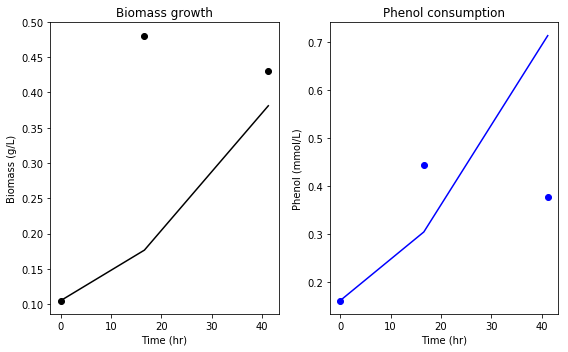

In [239]:
od_1 = od_df[od_df['Line Name'] == 'EVOL40-G']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL40-G']
stats_for_trial(od_1, sub_1, 180.16, display=True)

### Stats for low N WT glucose condition

growth_rate = 0.039 hr-1
yield coefficient = 1.834 g biomass / mmol substrate
substrate consumption rate = 0.021 mmol substrate/gram biomass * hr


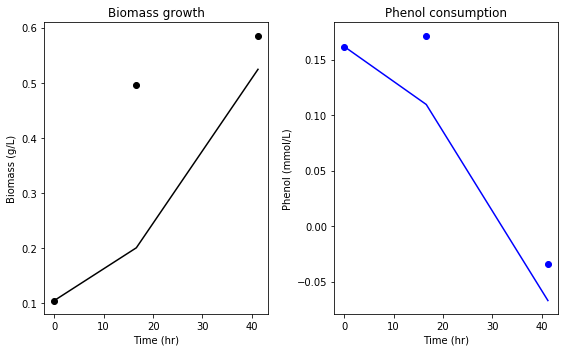

In [240]:
od_1 = od_df[od_df['Line Name'] == 'WT-G-N']
sub_1 = sub_df[sub_df['Line Name'] == 'WT-G-N']
stats_for_trial(od_1, sub_1, 180.16, display=True)

### Stats for low N Evol33 glucose condition

growth_rate = 0.033 hr-1
yield coefficient = 1.006 g biomass / mmol substrate
substrate consumption rate = 0.033 mmol substrate/gram biomass * hr


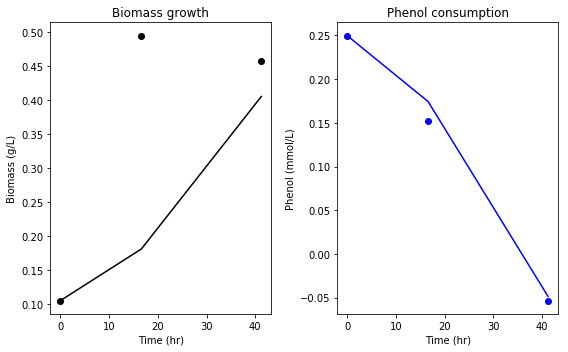

In [241]:
od_1 = od_df[od_df['Line Name'] == 'EVOL33-G-N']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL33-G-N']
stats_for_trial(od_1, sub_1, 180.16, display=True)

### Stats for low N Evol40 glucose condition

growth_rate = 0.034 hr-1
yield coefficient = 2.029 g biomass / mmol substrate
substrate consumption rate = 0.017 mmol substrate/gram biomass * hr


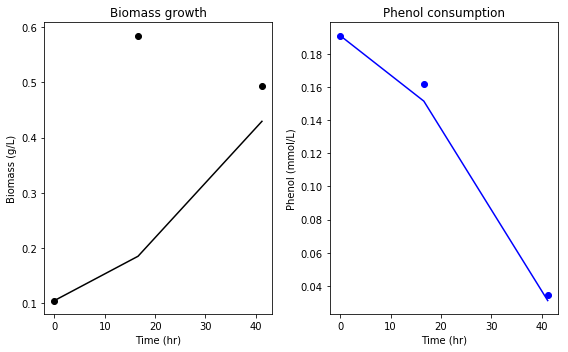

In [242]:
od_1 = od_df[od_df['Line Name'] == 'EVOL40-G-N']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL40-G-N']
stats_for_trial(od_1, sub_1, 180.16, display=True)

## Henson Data
Load OD and substrate concentration curves

In [243]:
od_filename = '../../EDD_Henson_data/Henson_ODD_data.csv'
substrate_filename = '../../EDD_Henson_data/Henson_metabolomics_data.csv'

od_df = pd.read_csv(od_filename)
sub_df = pd.read_csv(substrate_filename)

od_df['Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*od_df['Value']

print(f'substrate data has {len(sub_df)} lines')
print(f'OD data has {len(od_df)} lines')

substrate data has 48 lines
OD data has 60 lines


In [244]:
def stats_for_trial(growth_data, substrate_data, molar_mass, display=False, max_time=0):
    
    biomass_values = growth_data['Biomass Conc']
    biomass_times = growth_data['Time']
    biomass_init = list(biomass_values)[0]

    substrate_values = substrate_data['Value']*1000/molar_mass
    substrate_times = substrate_data['Time']
    substrate_init = list(substrate_values)[0]
    
    # growth is the slope of log(biomass) vs. time
    growth_rate, _, _, _, _ = linregress(biomass_times, [math.log(val) for val in biomass_values])
    
    # biomass X = X0*e^(μ*t)
    # This is different from above to ensure that there is a biomass value for every substrate measurement
    biomass_sim = [biomass_init*math.exp(growth_rate*time) for time in substrate_times]
    
    # actual consumption = S0 - S
    sub_consumed = [substrate_init - sub_value for sub_value in substrate_values]
    
    # new biomass X = X0 - X
    biomass_sim_growth = [sim_value - biomass_init for sim_value in biomass_sim ]
    
    # yield is the amount of biomass that can be made from a mmol of substrate
    yield_coeff, _, _, _, _ = linregress(sub_consumed, biomass_sim_growth)

    # S = S0 - (1/yield)*X
    substrate_sim = [substrate_init - 1/yield_coeff*val for val in biomass_sim_growth]
    
    substrate_consumption_rate = (1/yield_coeff) * growth_rate

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
    axes[0].plot(biomass_times, biomass_values, 'o', color='black')
    axes[0].plot(substrate_times, biomass_sim, '-', color='black')
    axes[1].plot(substrate_times, substrate_values, 'o', color='blue')
    axes[1].plot(substrate_times, substrate_sim, '-', color='blue')
    axes[0].set_title('Biomass growth')
    axes[1].set_title('Phenol consumption')
    axes[0].set_xlabel('Time (hr)')
    axes[1].set_xlabel('Time (hr)')
    axes[0].set_ylabel('Biomass (g/L)')
    axes[1].set_ylabel('Phenol (mmol/L)')
    fig.tight_layout()
    
    if display:
        print(f'growth_rate = {growth_rate:.3f} hr-1')
        print(f'yield coefficient = {yield_coeff:.3f} g biomass / mmol substrate')
        print(f'substrate consumption rate = {substrate_consumption_rate:.3f} mmol substrate/gram biomass * hr')
    else:
        return growth_rate, yield_coeff, substrate_consumption_rate

growth_rate = 0.065 ± 0.001 hr-1
yield coefficient = 0.046 ± 0.005 g biomass / mmol substrate
substrate consumption rate = 1.422 ± 0.129 mmol substrate/gram biomass * hr


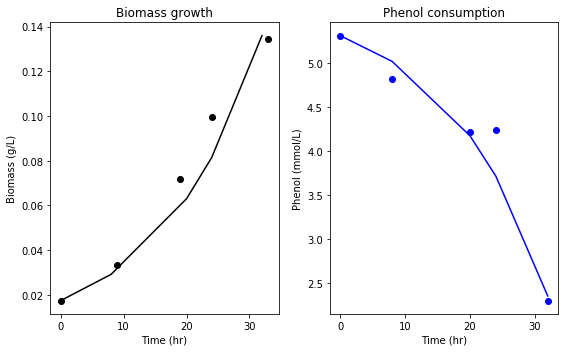

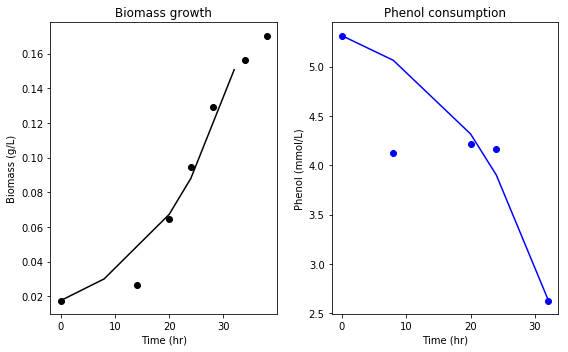

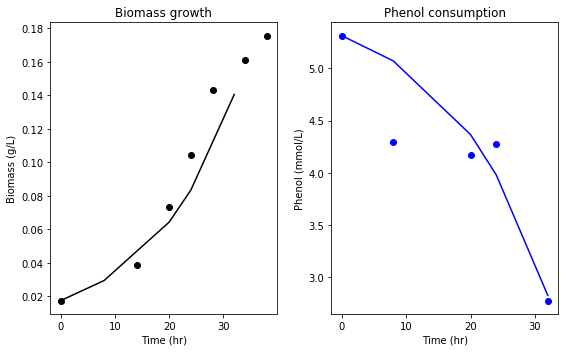

In [245]:
stats_for_condtion(od_df, sub_df,'WT-P-R1', 'WT-P-R2', 'WT-P-R3', 94.11, max_time = 40)

growth_rate = 0.080 ± 0.003 hr-1
yield coefficient = 0.039 ± 0.002 g biomass / mmol substrate
substrate consumption rate = 2.069 ± 0.023 mmol substrate/gram biomass * hr


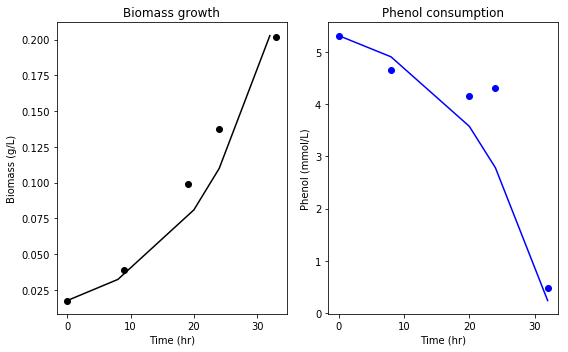

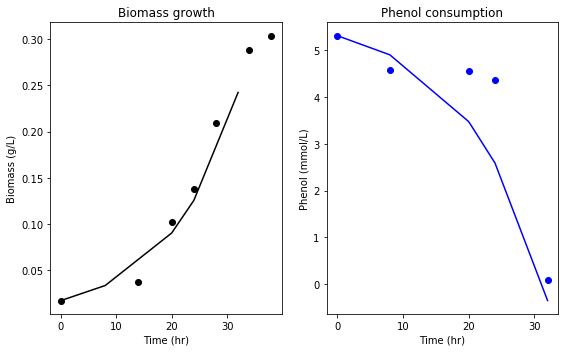

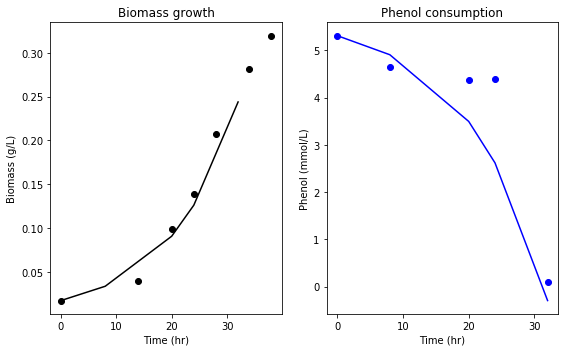

In [246]:
stats_for_condtion(od_df, sub_df, 'PVHG6-P-R1', 'PVHG6-P-R2', 'PVHG6-P-R3', 94.11, max_time=40)